In [13]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random

plt.rcParams.update({'font.size': 7})

## Deterministic Environment: $P(s',r|s,a)=\{0,1\}$
## Stochastic Environment: $\sum_{s',r}P(s',r|s,a)=1$

In [14]:
class GridWorld(gym.Env):
    def __init__(self, verbose=False, env_type='Deterministic'):
        self.grid_size = 10
        self.start = (0, 0)
        self.specialSquares = [(0,2), (7,8), (8,7), (8,3), (4,7), (9,9)]
        self.rewards = [1.5, -2, -2, 4, -5, 5]
        self.ultimate_goal = self.specialSquares[-1]
        self.ultimate_reward = self.rewards[-1]
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((spaces.Discrete(self.grid_size),spaces.Discrete(self.grid_size)))
        self.verbose = verbose
        self.env_type = env_type
        self.reset()

    def reset(self):
        self.state = self.start
        self.specialSquares = [(0,2), (7,8), (8,7), (8,3), (4,7), (9,9)]
        self.rewards = [1.5, -2, -2, 4, -5, 5]
        self.ultimate_goal = self.specialSquares[-1]
        self.ultimate_reward = self.rewards[-1]
        self.cumulativeReward = 0
        return self.state

    def step(self, action):
        if self.env_type == 'Deterministic': # deterministic environment enabled
            x, y = self.state
            if action == 0:
                x = max(x - 1, 0) # move down
            elif action == 1:
                x = min(x + 1, self.grid_size - 1) # move up
            elif action == 2:
                y = max(y - 1, 0) # move left
            elif action == 3:
                y = min(y + 1, self.grid_size - 1) # move right
            self.state = (x, y)
        
        elif self.env_type == 'Stochastic': # stochastic environment enabled
            # at (9,8), give a 20% chance that the agent will be teleported to to (0,7)
            x, y = self.state
            teleported = False
            if x == 9 and y == 8 and np.random.random() <= 0.2:
                self.state = (0,7)
                if self.verbose:
                    print('TELEPORTED')
                teleported = True
            if not teleported:
                if action == 0:
                    x = max(x - 1, 0) # move left
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move left then down
                elif action == 1:
                    x = min(x + 1, self.grid_size - 1) # move right
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move right then down
                elif action == 2:
                    y = max(y - 1, 0) # move down
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move down then down
                elif action == 3:
                    y = min(y + 1, self.grid_size - 1) # move up 
                    if np.random.random() < 0.15:
                        y = max(y - 1, 0) # move up then down
                self.state = (x, y)

        self.cumulativeReward -= 0.05
        
        instantReward = self.computeInstantReward(self.state)

        self.cumulativeReward += instantReward

        done = self.state == self.ultimate_goal # done if we reach the +5 reward at (9, 9)

        if self.verbose:
            print('action:', action, 'state:', self.state, 'reward:', self.cumulativeReward, 'done:', done)
        return self.state, self.cumulativeReward, done, {}
    
    def computeInstantReward(self, state):
        if state in self.specialSquares:
            reward = self.rewards[self.specialSquares.index(state)]
            self.specialSquares.pop(self.specialSquares.index(state))
            self.rewards.pop(self.rewards.index(reward))
            return reward
        else:
            return 0

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if (i, j) in self.specialSquares:
                    grid[i,j] = self.rewards[self.specialSquares.index((i, j))]
                    plt.text(j, i, str(grid[i,j]), ha='center', va='center', color='w')

        grid[self.state] = -1
        plt.text(self.state[1], self.state[0], 'LARS', ha='center', va='center', color='w')
        if self.env_type == 'Stochastic':
            plt.text(8, 9, 'teleport', ha='center', va='center', color='w')

        plt.xticks(np.arange(0, self.grid_size, 1))
        plt.yticks(np.arange(0, self.grid_size, 1))
        plt.imshow(grid, cmap='viridis',origin='lower')
        plt.show()

## Training Agent using Q-Learning in Deterministic Environment

In [15]:
# reset for deterministic environment
env = GridWorld(verbose=False, env_type='Deterministic')
env.reset()

print("Action Space: ", env.action_space)
print("State Space: ", env.observation_space)

# initialize Q-table
Q = np.zeros([env.grid_size ** 2, env.action_space.n])

# create a dictionary to map state to index
state_to_index = {}
for i in range(env.grid_size):
    for j in range(env.grid_size):
        state_to_index[(i, j)] = i * env.grid_size + j

# hyperparameters
alpha = 0.1
gamma = 0.96
epsilon = 0.99
max_epsilon = 1.0
min_epsilon = 0.001
epsilon_decay = 0.001
episodes = 10000
max_steps = 10 ** 10

episodeRewards = []
numStepsList = []
epsilonList = []

for episode in range(1, episodes+1):
    state = env.reset()
    cumulativeEpisodeReward = 0
    epochs, stepCount, penalties, reward, = 0, 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon: # determine exploration vs exploitation 
            action = env.action_space.sample() # explore action space
        else:
            action = np.argmax(Q[state_to_index[state]]) # exploit action space by choosing the action with the highest Q-value for the current state
        
        next_state, reward, done, info = env.step(action)
        old_value = Q[state_to_index[state], action]
        next_max = np.max(Q[state_to_index[next_state]])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        Q[state_to_index[state], action] = new_value

        cumulativeEpisodeReward += reward
        state = next_state
        epochs += 1
        stepCount += 1

    epsilonList.append(epsilon)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)
    
    episodeRewards.append(cumulativeEpisodeReward)
    numStepsList.append(stepCount)
    if episode % 10000 == 0:
        print("Episode:", episode)

Action Space:  Discrete(4)
State Space:  Tuple(Discrete(10), Discrete(10))
Episode: 10000


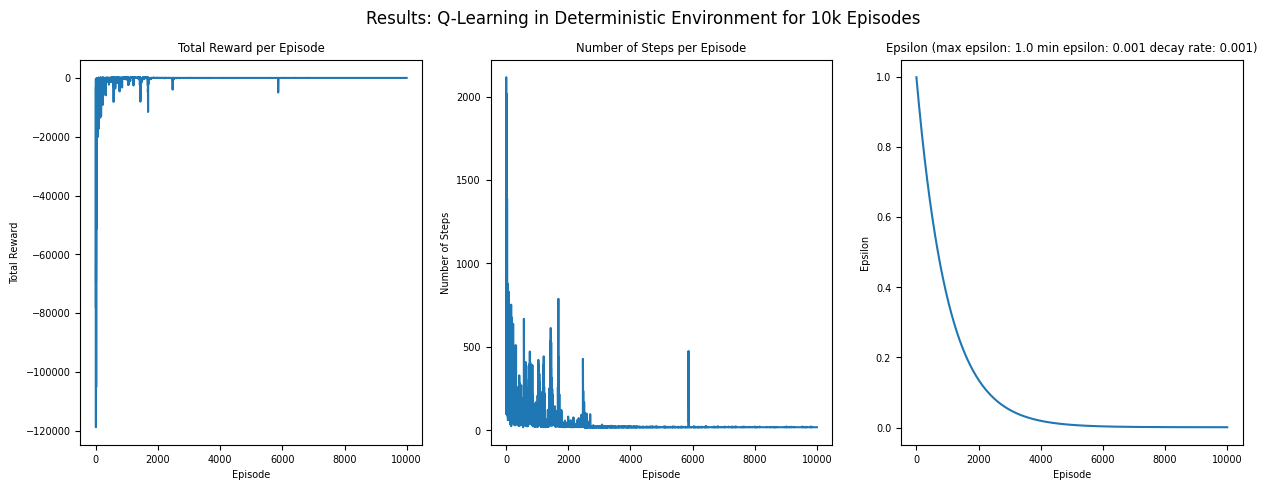

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(episodeRewards)
ax1.set_title('Total Reward per Episode')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax2.plot(numStepsList)
ax2.set_title('Number of Steps per Episode')
ax2.set_ylabel('Number of Steps')
ax2.set_xlabel('Episode')
ax3.plot(epsilonList[1:])
ax3.set_title('Epsilon (max epsilon: '+str(max_epsilon)+' min epsilon: '+str(min_epsilon)+' decay rate: '+str(epsilon_decay)+')')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Epsilon')
fig.suptitle('Deterministic Environment')
fig.suptitle('Results: Q-Learning in Deterministic Environment for 10k Episodes', fontsize=12)
plt.show()

## Training Agent using Q-Learning in Stochastic Environment

In [17]:
# reset for stochastic environment
env = GridWorld(verbose=False, env_type='Stochastic')
env.reset()

print("Action Space: ", env.action_space)
print("State Space: ", env.observation_space)

# initialize Q-table
Q = np.zeros([env.grid_size ** 2, env.action_space.n])

# create a dictionary to map state to index
state_to_index = {}
for i in range(env.grid_size):
    for j in range(env.grid_size):
        state_to_index[(i, j)] = i * env.grid_size + j

# hyperparameters
alpha = 0.1
gamma = 0.96
epsilon = 0.99
max_epsilon = 1.0
min_epsilon = 0.001
epsilon_decay = 0.001
episodes = 10000
max_steps = 10 ** 10

episodeRewards = []
numStepsList = []
epsilonList = []

for episode in range(1, episodes+1):
    state = env.reset()
    cumulativeEpisodeReward = 0
    epochs, stepCount, penalties, reward, = 0, 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon: # determine exploration vs exploitation 
            action = env.action_space.sample() # explore action space
        else:
            action = np.argmax(Q[state_to_index[state]]) # exploit action space by choosing the action with the highest Q-value for the current state
        
        next_state, reward, done, info = env.step(action)
        old_value = Q[state_to_index[state], action]
        next_max = np.max(Q[state_to_index[next_state]])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        Q[state_to_index[state], action] = new_value

        cumulativeEpisodeReward += reward
        state = next_state
        epochs += 1
        stepCount += 1

    epsilonList.append(epsilon)
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay * episode)
    
    episodeRewards.append(cumulativeEpisodeReward)
    numStepsList.append(stepCount)
    if episode % 10000 == 0:
        print("Episode:", episode)

Action Space:  Discrete(4)
State Space:  Tuple(Discrete(10), Discrete(10))
Episode: 10000


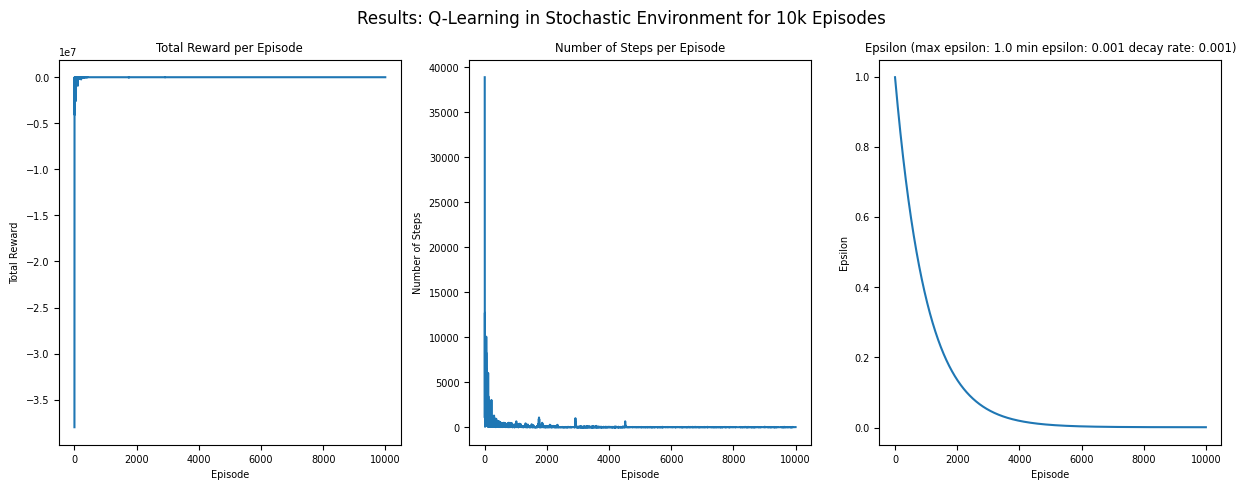

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(episodeRewards)
ax1.set_title('Total Reward per Episode')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax2.plot(numStepsList)
ax2.set_title('Number of Steps per Episode')
ax2.set_ylabel('Number of Steps')
ax2.set_xlabel('Episode')
ax3.plot(epsilonList[1:])
ax3.set_title('Epsilon (max epsilon: '+str(max_epsilon)+' min epsilon: '+str(min_epsilon)+' decay rate: '+str(epsilon_decay)+')')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Epsilon')
fig.suptitle('Results: Q-Learning in Stochastic Environment for 10k Episodes', fontsize=12)
plt.show()